# PREAMBLE CODE

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from IPython.display import clear_output
import time

## DATASETS

### MNIST loader setup

In [52]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', 
                   train=False, 
                   download=True, 
                   transform=transforms.Compose([
                       transforms.ToTensor(), 
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])
    ),
    batch_size=1, shuffle=True)

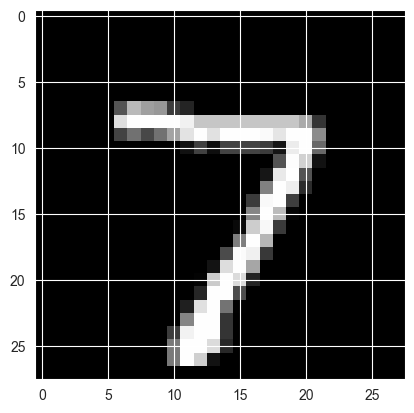

In [53]:
ex_img = test_loader.dataset[0][0].squeeze()

plt.imshow(ex_img, cmap='gray')

### FashionMNIST loader setup

### 3rd dataset setup

## LeNet (pre-trained) model setup

In [54]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    
model = LeNet().to(device)
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─Conv2d: 1-2                            [1, 64, 24, 24]           18,496
├─Dropout: 1-3                           [1, 64, 12, 12]           --
├─Linear: 1-4                            [1, 128]                  1,179,776
├─Dropout: 1-5                           [1, 128]                  --
├─Linear: 1-6                            [1, 10]                   1,290
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 12.05
Input size (MB): 0.00
Forward/backward pass size (MB): 0.47
Params size (MB): 4.80
Estimated Total Size (MB): 5.27

In [55]:
path = r'lenet_mnist_model.pth'
model.load_state_dict(torch.load(path, map_location=device))

<All keys matched successfully>

In [56]:
model.eval()

LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## Some helper functions

In [57]:
# from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [58]:
# MODIFED from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
# changelog:
# added algo parameter to the function signature and call to the algo function as to define test funct only once and call it with the desired attack algo
# added alpha parameter to the function signature as to define test funct only once and call it with the desired step size
# added num_iter parameter to the function signature
# adapted function returns to fit running function
# if statement for FSGM (needs some tinkering cuz the code is too long)

def test(model, device, test_loader, epsilon, algo, alpha, num_iter):
    if algo == 'FSGM_attack':
        correct = 0
        adv_examples = []

        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data.requires_grad = True
            output = model(data)
            init_pred = output.max(1, keepdim=True)[1]

            if init_pred.item() != target.item():
                continue

            loss = F.nll_loss(output, target)
            model.zero_grad()
            loss.backward()
            data_grad = data.grad.data
            data_denorm = denorm(data)

            perturbed_data = FSGM_attack(data_denorm, epsilon, data_grad)

            perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)
            output = model(perturbed_data_normalized)

            final_pred = output.max(1, keepdim=True)[1]
            if final_pred.item() == target.item():
                correct += 1
                if epsilon == 0 and len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
            else:
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

        final_acc = correct / float(len(test_loader))
        print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

        return final_acc, adv_examples

    else:
        correct = 0
        adv_examples = []
        iteration_accuracies = []
        step_sizes = []
        iteration_times = []

        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data.requires_grad = True
            output = model(data)
            init_pred = output.max(1, keepdim=True)[1]

            if init_pred.item() != target.item():
                continue

            loss = F.nll_loss(output, target)
            model.zero_grad()
            loss.backward()
            data_grad = data.grad.data
            data_denorm = denorm(data)

            start_time = time.time()
            if algo == PGD_const:
                perturbed_data = PGD_const(model, data_denorm, target, epsilon, alpha, num_iter)
            else:
                perturbed_data = algo(model, data_denorm, target, epsilon, num_iter, alpha)
            iteration_time = time.time() - start_time

            perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)
            output = model(perturbed_data_normalized)
            final_pred = output.max(1, keepdim=True)[1]

            if final_pred.item() == target.item():
                correct += 1
                if epsilon == 0 and len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
            else:
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

            iteration_accuracies.append(correct / float(len(test_loader)))
            step_sizes.append(epsilon)
            iteration_times.append(iteration_time)

        final_acc = correct / float(len(test_loader))
        print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

        return final_acc, adv_examples, iteration_accuracies, step_sizes, iteration_times

In [59]:
def plot_metrics(epsilons, accuracies, iteration_accuracies, iteration_times, step_sizes):
    fig, axs = plt.subplots(4, 1, figsize=(10, 24))
    
    sns.lineplot(ax=axs[0], x=epsilons, y=accuracies, label="Accuracy vs Epsilon", linewidth=0.75, errorbar=None)
    axs[0].set_xlabel('Epsilon', fontsize=14)
    axs[0].set_ylabel('Accuracy', fontsize=14)
    axs[0].set_title("Accuracy vs Epsilon", fontsize=16)

    sns.lineplot(ax=axs[1], x=np.arange(len(iteration_accuracies)), y=iteration_accuracies)
    axs[1].set_title('Accuracy vs Iteration')
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Accuracy')

    sns.lineplot(ax=axs[2], x=np.arange(len(iteration_times)), y=iteration_times)
    axs[2].set_title('Accuracy vs Time')
    axs[2].set_xlabel('Iteration')
    axs[2].set_ylabel('Time (s)')

    sns.lineplot(ax=axs[3], x=np.arange(len(step_sizes)), y=step_sizes)
    axs[3].set_title('Step Size Behavior')
    axs[3].set_xlabel('Iteration')
    axs[3].set_ylabel('Step Size')

    plt.tight_layout()
    plt.show()

In [60]:
# MODIFED from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
# changelog: made it a function instead of the whole code so that we slim the code

def plot_examples(examples, epsilons):
    cnt = 0
    plt.figure(figsize=(8, 10))
    for i in range(len(epsilons)):
        for j in range(len(examples[i])):
            cnt += 1
            plt.subplot(len(epsilons), len(examples[0]), cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
            orig, adv, ex = examples[i][j]
            plt.title(f"{orig} -> {adv}")
            plt.imshow(ex, cmap="gray")
    plt.tight_layout()
    plt.show()

In [61]:
# function runs the attack for each epsilon and plots the accuracy, and at the end plots the examples

def RUN(model, device, test_loader, algo, num_iter, epsilons, alpha):
    accuracies, examples, all_iteration_accuracies, all_step_sizes, all_iteration_times = [], [], [], [], []

    for eps in epsilons:
        acc, ex, iteration_accuracies, step_sizes, iteration_times = test(model, device, test_loader, eps, algo, alpha, num_iter)
        accuracies.append(acc)
        examples.append(ex)
        all_iteration_accuracies.extend(iteration_accuracies)
        all_step_sizes.extend(step_sizes)
        all_iteration_times.extend(iteration_times)

    plot_examples(examples, epsilons)
    plot_metrics(epsilons, accuracies, all_iteration_accuracies, all_iteration_times, all_step_sizes)

## Optimization ''hyperparams'' setup

### Perturbation set bounds

In [62]:
epsilons = [0, .05, .1, .15, .2, .25, .3, .35]

### Number of iterations

In [63]:
num_iter = 40

### Constant step sizes

##### Unit step size

In [64]:
alpha_unit = 1

##### Lipschitz constant dependent step size

In [65]:
def lipschitz_constant(model):
    L = 0  # initialize

    for layer in model.children():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            
            weight = layer.weight.data # extract weight data
            
            singular_values = torch.svd(weight).S     # as we did initially in the homework, we approximate the Lipschitz
            L = max(L, singular_values.max().item())  # constant as the maximum singular value of the weight matrix
    
    return L

L = lipschitz_constant(model)

alpha_lipschitz = 1 / L

alpha_lipschitz

0.14922538993069884

### Adaptive step sizes

##### Diminishing step size

In [66]:
def alpha_dim(num_iter):
    alphas = [2 / (k + 2) for k in range(num_iter)] # defined as a list cuz it's easier to call the i-th element
    return alphas

##### Exact line search

From Rinaldi's survey paper:

The exact line search method aims to find the optimal step size $ \( \alpha \)$  that minimizes the objective function along the direction of the gradient descent.

$ \[ \alpha_k = \min_{\alpha \in [0, \alpha_{\text{max}}^k]} \varphi(\alpha) \] $, where:

$ \[ \varphi(\alpha) = f(x_k + \alpha d_k) \]$ 

- $\( x_k \)$: Current point in the parameter space.
- $\( d_k \)$: Descent direction (typically the negative gradient).
- $\( \alpha_{\text{max}}^k \)$: Maximum allowable step size.
- $\( \varphi(\alpha) \)$: Objective function along the direction $\( d_k \)$ with step size $\( \alpha \)$.

The goal is to find the smallest $\( \alpha \)$ that minimizes $\( \varphi(\alpha) \)$.

In [67]:
# define initial step size

alpha_max = 0.01 # for adversarial attacks on images with pixel values normalized between 0 and 1, α_max = 0.1 or α_max = 0.01 is a common choice.

In [68]:
def exact_LS(model, image, target, data_grad, num_iter):
    def objective_function(alpha):
        perturbed_image = image + alpha * data_grad
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        output = model(perturbed_image)
        loss = F.cross_entropy(output, target)
        return loss.item()

    alpha_range = torch.linspace(0, alpha_max, num_iter)
    losses = [objective_function(alpha) for alpha in alpha_range]
    best_alpha = alpha_range[torch.argmin(torch.tensor(losses))]

    return best_alpha

##### Armijo rule

From Rinaldi's survey paper:


$\[ \alpha_k = \min_{\alpha \in [0, \alpha_{\text{max}}^k]} \varphi(\alpha) \]$, where:

$\[ \varphi(\alpha) = f(x_k + \alpha d_k) \]$

- $\( x_k \)$: Current point in the parameter space.
- $\( d_k \)$: Descent direction (typically the negative gradient).
- $\( \alpha_{\text{max}}^k \)$: Maximum allowable step size.
- $\( \varphi(\alpha) \)$: Objective function along the direction $\( d_k \)$ with step size $\( \alpha \)$.

The goal is to find the smallest $\( \alpha \)$ that minimizes $\( \varphi(\alpha) \)$.

In [69]:
delta = 0.5
gamma = 0.1
M = 1000 

def armijo(model, image, target, data_grad):
    alpha = alpha_max
    m = 0

    while m < M:
        perturbed_image = image + alpha * data_grad
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        output = model(perturbed_image)
        loss = F.cross_entropy(output, target)
        
        if loss.item() <= F.cross_entropy(model(image), target).item() + gamma * alpha * data_grad.norm():
            break
        else:
            alpha *= delta
            m += 1

    return alpha

# Non-FW Attacks

## Attack PGD

In [70]:
# could not slim the code to only one function
# as for constant step sizes, the attack follows an algo structure that requires a function arg that should not be passed in adaptive step sizes algos
# so at most I could define two functions for each algo, one for constant step sizes and one for adaptive step sizes

In [71]:
def PGD_const(model, image, target, epsilon, alpha, num_iter):
    perturbed_image = image.clone().detach().requires_grad_(True)
    for _ in range(num_iter):
        # Zero all existing gradients
        perturbed_image.requires_grad = True

        # Forward pass the data through the model
        output = model(perturbed_image)
        loss = torch.nn.functional.cross_entropy(output, target)
            
        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect the element-wise sign of the data gradient
        data_grad = perturbed_image.grad.data
        
        # call the constant step size
        if alpha == 'alpha_unit':
            best_alpha = alpha_unit
        elif alpha == 'alpha_lipschitz':
            best_alpha = alpha_lipschitz

        perturbed_image = perturbed_image + best_alpha * data_grad.sign() # move in the direction of the gradient
        perturbation = torch.clamp(perturbed_image - image, -epsilon, epsilon) # clip to stay within the given epsilon
        perturbed_image = torch.clamp(image + perturbation, 0, 1).detach() # apply perturbation and clip within valid pixel range (we de-normed to [0,1])

    # Return the final perturbed image after all iterations
    return perturbed_image

In [72]:
def PGD_adapt(model, image, target, epsilon, num_iter, search_method):
    perturbed_image = image.clone().detach().requires_grad_(True)

    for i in range(num_iter):
        perturbed_image.requires_grad = True

        output = model(perturbed_image)
        loss = F.cross_entropy(output, target)

        model.zero_grad()
        loss.backward()

        data_grad = perturbed_image.grad.data

        if search_method == "exact":
            best_alpha = exact_LS(model, perturbed_image, target, data_grad, num_iter)
        elif search_method == "armijo":
            best_alpha = armijo(model, perturbed_image, target, data_grad)
        elif search_method == "alpha_dim":
            alphas = alpha_dim(num_iter)
            best_alpha = alphas[i] # # use the precomputed alpha value (since in this case it's only dependent on the number of iterations)

        perturbed_image = perturbed_image + best_alpha * data_grad.sign() # move in the direction of the gradient
        perturbation = torch.clamp(perturbed_image - image, -epsilon, epsilon) # clip to stay within the given epsilon
        perturbed_image = torch.clamp(image + perturbation, 0, 1).detach() # apply perturbation and clip within valid pixel range (we de-normed to [0,1])

    return perturbed_image

##### Attack PGD unit step size

In [ ]:
RUN(model, device, test_loader, PGD_const, num_iter, epsilons, 'alpha_unit')

Epsilon: 0	Test Accuracy = 9912 / 10000 = 0.9912
Epsilon: 0.05	Test Accuracy = 9765 / 10000 = 0.9765


##### Attack PGD lipschitz constant dependent step size

In [ ]:
RUN(model, device, test_loader, PGD_const, num_iter, epsilons, 'alpha_lipschitz')

##### Attack PGD diminishing step size

In [ ]:
RUN(model, device, test_loader, PGD_adapt, num_iter, "alpha_dim")

##### Attack PGD exact line search

In [ ]:
RUN(model, device, test_loader, PGD_adapt, num_iter, "exact")

##### Attack PGD armijo rule

In [ ]:
RUN(model, device, test_loader, PGD_adapt, num_iter, "armijo")

## Attack FSGM

In [ ]:
# MODIFIED from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
# no step size since it is not an iterative method
# changelog:
# added model, target, data_grad, alpha and num_iter parameters to the function signature to fit it to the test function

# FGSM attack code
def FSGM_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:
# since it is not an iterative model, we can't plot time per iteration and accuracy per iteration metrics, so we'll use raw code
# MODIFIED from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
# changelog:
# fit the function to the test function's if statement, with of course None as step size and number of iterations
## test function may be further slimmed by avoiding some repetition putting the if statement somewhere else, but it's not a big deal

accuracies = []
examples = []

# Run test for each epsilon
def RUN_FSGM(model, device, test_loader, epsilons):
    for eps in epsilons:
        acc, ex = test(model, device, test_loader, eps, 'FSGM_attack', None, None)
        accuracies.append(acc)
        examples.append(ex)
        
    plt.figure(figsize=(5,5))
    plt.plot(epsilons, accuracies, "*-")
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xticks(np.arange(0, .35, step=0.05))
    plt.title("Accuracy vs Epsilon")
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()    
    
    plot_examples(examples, epsilons)
    
RUN_FSGM(model, device, test_loader, epsilons)

# FW (and variants) Attacks

In [ ]:
# merge tanner code